# Лабораторная работа №5

Задания:
1. Провести классификацию найденного датасета, методами решающего дерева и случайного леса. В формате Markdown писать пояснения. Объяснить почему были выбраны именно такие гиперпараметры, была ли перекрестная проверка, и т.д.

<table>
<tr><th>Название столбца</th><th>Описание</th></tr>
<tr><td>ID</td><td>ID каждого клиента</td></tr>
<tr><td>LIMIT_BAL</td><td>Сумма выданного кредита в долларах NT (включает индивидуальный и семейный/дополнительный кредит)</td></tr>
<tr><td>SEX</td><td>Пол (1=мужской, 2=женский)</td></tr>
<tr><td>EDUCATION</td><td>(1=аспирантура, 2=университет, 3=средняя школа, 4=другое, 5=неизвестно, 6=неизвестно)</td></tr>
<tr><td>MARRIAGE</td><td>Семейное положение (1=замужем, 2=не замужем, 3=другое)</td></tr>
<tr><td>AGE</td><td>Возраст в годах</td></tr>
<tr><td>PAY_0</td><td>Статус погашения в сентябре 2005 года (-2=нет потребления, -1=оплачиваю должным образом, 0=использование возобновляемого кредита, 1=задержка платежа на один месяц, 2=задержка платежа на два месяца, ... )</td></tr>
<tr><td>PAY_2</td><td>Статус погашения в августе 2005 года (шкала такая же, как и выше)</td></tr>
<tr><td>PAY_3</td><td>Статус погашения в июле 2005 года (шкала та же, что и выше)</td></tr>
<tr><td>PAY_4</td><td>Статус погашения в июне 2005 года (шкала такая же, как выше)</td></tr>
<tr><td>PAY_5</td><td>Статус погашения в мае, 2005 (шкала такая же, как выше)</td></tr>
<tr><td>PAY_6</td><td>Статус погашения в апреле 2005 года (шкала такая же, как выше)</td></tr>
<tr><td>BILL_AMT1</td><td>Сумма выписки счета в сентябре, 2005 (NT доллар)</td></tr>
<tr><td>BILL_AMT2</td><td>Сумма выписки по счету за август, 2005 (NT доллар)</td></tr>
<tr><td>BILL_AMT3</td><td>Сумма выписки счета за июль, 2005 (NT доллар)</td></tr>
<tr><td>BILL_AMT4</td><td>Сумма выписки счета за июнь, 2005 (NT доллар)</td></tr>
<tr><td>BILL_AMT5</td><td>Сумма выписки счета за май, 2005 (NT доллар)</td></tr>
<tr><td>BILL_AMT6</td><td>Сумма выписки счета за апрель, 2005 (NT доллар)</td></tr>
<tr><td>PAY_AMT1 </td><td>Сумма предыдущего платежа в сентябре, 2005 (NT доллар)</td></tr>
<tr><td>PAY_AMT2 </td><td>Сумма предыдущего платежа в августе, 2005 (NT доллар)</td></tr>
<tr><td>PAY_AMT3 </td><td>Сумма предыдущего платежа в июле, 2005 (NT доллар)</td></tr>
<tr><td>PAY_AMT4</td><td>Сумма предыдущего платежа в июне, 2005 (NT доллар)</td></tr>
<tr><td>PAY_AMT5</td><td>Сумма предыдущего платежа в мае, 2005 (NT доллар)</td></tr>
<tr><td>PAY_AMT6</td><td>Сумма предыдущего платежа в апреле, 2005 (NT доллар)</td></tr>
<tr><td>default payment next montr </td><td>Платеж по умолчанию (1=да, 0=нет)</td></tr>
</table>

In [1]:
import pandas
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report,roc_auc_score,roc_curve,accuracy_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plot
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
data = pandas.read_csv("data.csv", sep=',', index_col='ID');

## Обработка данных
- Пол, семейное положение и возраст - категорийные признаки.
- Значения EDUCATION 0,4,5,6 имеют одинаковый смысл.
- Значения MARRIAGE 0,3 имеют одинаковый смысл.

In [2]:
data[['SEX','MARRIAGE','EDUCATION']] = data[['SEX','MARRIAGE','EDUCATION']].astype('object')
data.loc[data["MARRIAGE"]==3, "MARRIAGE"] = 0
data.loc[data["EDUCATION"] > 3, "EDUCATION"] = 0

## Разметка данных

- "Обучающий набор" - 70% = 21000 записей
- Тестовый набор - 30% = 9000 записей

Затем для данных проводится нормализация. 

Также для методов, требующих только положительные значения признаков, создаётся отдельный набор данных, удовлетворяющий этим условиям.

In [3]:
data.rename(columns={'PAY_0': 'PAY_1'}, inplace=True)
X = data.drop("default payment next month", axis=1, inplace=False)
Y = data["default payment next month"]
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.3, stratify=Y,)
scaler = StandardScaler()
train_X_std = train_X.copy()
test_X_std = test_X.copy()

train_X_std['LIMIT_BAL'] = scaler.fit_transform(train_X['LIMIT_BAL'].values.reshape(-1, 1))
test_X_std['LIMIT_BAL'] = scaler.transform(test_X['LIMIT_BAL'].values.reshape(-1, 1))
train_X_std['AGE'] = scaler.fit_transform(train_X['AGE'].values.reshape(-1, 1))
test_X_std['AGE'] = scaler.transform(test_X['AGE'].values.reshape(-1, 1))
for i in range(1,7):
    train_X_std['PAY_' + str(i)] = scaler.fit_transform(train_X['PAY_' + str(i)].values.reshape(-1, 1))
    test_X_std['PAY_' + str(i)] = scaler.transform(test_X['PAY_' + str(i)].values.reshape(-1, 1))
    train_X_std['BILL_AMT' + str(i)] = scaler.fit_transform(train_X['BILL_AMT' + str(i)].values.reshape(-1, 1))
    test_X_std['BILL_AMT' + str(i)] = scaler.transform(test_X['BILL_AMT' + str(i)].values.reshape(-1, 1))
    train_X_std['PAY_AMT' + str(i)] = scaler.fit_transform(train_X['PAY_AMT' + str(i)].values.reshape(-1, 1))
    test_X_std['PAY_AMT' + str(i)] = scaler.transform(test_X['PAY_AMT' + str(i)].values.reshape(-1, 1))

positive_train_X_std = train_X.copy()
positive_test_X_std = test_X.copy()
scaler = MinMaxScaler()
positive_train_X_std['LIMIT_BAL'] = scaler.fit_transform(train_X['LIMIT_BAL'].values.reshape(-1, 1))
positive_test_X_std['LIMIT_BAL'] = scaler.transform(test_X['LIMIT_BAL'].values.reshape(-1, 1))
positive_train_X_std['AGE'] = scaler.fit_transform(train_X['AGE'].values.reshape(-1, 1))
positive_test_X_std['AGE'] = scaler.transform(test_X['AGE'].values.reshape(-1, 1))
for i in range(1,7):
    positive_train_X_std['PAY_' + str(i)] = scaler.fit_transform(train_X['PAY_' + str(i)].values.reshape(-1, 1))
    positive_test_X_std['PAY_' + str(i)] = scaler.transform(test_X['PAY_' + str(i)].values.reshape(-1, 1))
    positive_train_X_std['BILL_AMT' + str(i)] = scaler.fit_transform(train_X['BILL_AMT' + str(i)].values.reshape(-1, 1))
    positive_test_X_std['BILL_AMT' + str(i)] = scaler.transform(test_X['BILL_AMT' + str(i)].values.reshape(-1, 1))
    positive_train_X_std['PAY_AMT' + str(i)] = scaler.fit_transform(train_X['PAY_AMT' + str(i)].values.reshape(-1, 1))
    positive_test_X_std['PAY_AMT' + str(i)] = scaler.transform(test_X['PAY_AMT' + str(i)].values.reshape(-1, 1))

## Поиск наилучших параметров Decision Tree

Полный поиск по заданным значениям параметров для получения оценки.
Параметры оптимизируются путем перекрестной проверки по сетке параметров.

In [4]:
params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt','log2',None]
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(),    
    params,
    cv=5,
    n_jobs=16
)
grid_search.fit(train_X_std, train_Y)
print(grid_search.best_params_)

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}


## Поиск наилучших параметров Random Forest

Полный поиск по заданным значениям параметров для получения оценки.
Параметры оптимизируются путем перекрестной проверки по сетке параметров.

In [11]:
params = {
    'n_estimators': [50, 100, 150, 200],
    'criterion': ['gini', 'entropy', "log_loss"],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt','log2',None]
}

grid_search = GridSearchCV(
    RandomForestClassifier(),    
    params,
    cv=5,
    n_jobs=16
)
grid_search.fit(train_X_std, train_Y)
print(grid_search.best_params_)

{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}


## Классификация и статистика по результатам Decision Tree

In [15]:
classifier = DecisionTreeClassifier(criterion="entropy", max_depth=10, min_samples_leaf=2, min_samples_split=2, splitter="best") 
classifier.fit(train_X_std, train_Y)
test_predict_Y = classifier.predict(test_X_std)  
test_predict_proba_Y = classifier.predict_proba(test_X_std)[:,1]      

Точность на тестовой выборке: 0.8055555555555556


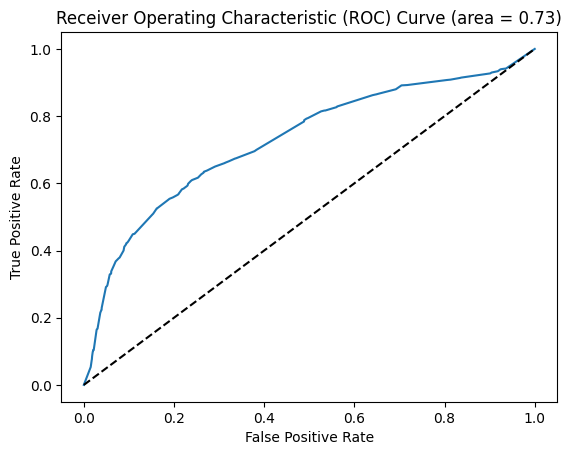

Classification Report of Test
               precision    recall  f1-score   support

           0       0.84      0.93      0.88      7009
           1       0.60      0.35      0.45      1991

    accuracy                           0.81      9000
   macro avg       0.72      0.64      0.66      9000
weighted avg       0.78      0.81      0.79      9000



In [16]:
def print_stats(test_Y,test_predict_Y,test_predict_proba_Y):
    print('Точность на тестовой выборке:',accuracy_score(test_Y,test_predict_Y))
    # Вычисление ROC-кривой и её параметров
    fpr, tpr, thresholds = roc_curve(test_Y, test_predict_proba_Y)

    # Построение ROC-кривой
    plot.plot(fpr, tpr)
    plot.plot([0, 1], [0, 1], 'k--')  # Случайное предсказание
    plot.xlabel('False Positive Rate')
    plot.ylabel('True Positive Rate')
    plot.title('Receiver Operating Characteristic (ROC) Curve (area = %0.2f)'% roc_auc_score(test_Y, test_predict_proba_Y))
    plot.show()

    print('Classification Report of Test\n',  classification_report(test_Y, test_predict_Y))
print_stats(test_Y,test_predict_Y,test_predict_proba_Y)

## Классификация и статистика по результатам Random Forest

In [27]:
classifier = RandomForestClassifier(criterion="entropy", max_depth=10, min_samples_leaf=1, min_samples_split=5, max_features=None, n_estimators=50, n_jobs=16) 
classifier.fit(train_X_std, train_Y)
test_predict_Y = classifier.predict(test_X_std)  
test_predict_proba_Y = classifier.predict_proba(test_X_std)[:,1]   

Точность на тестовой выборке: 0.8141111111111111


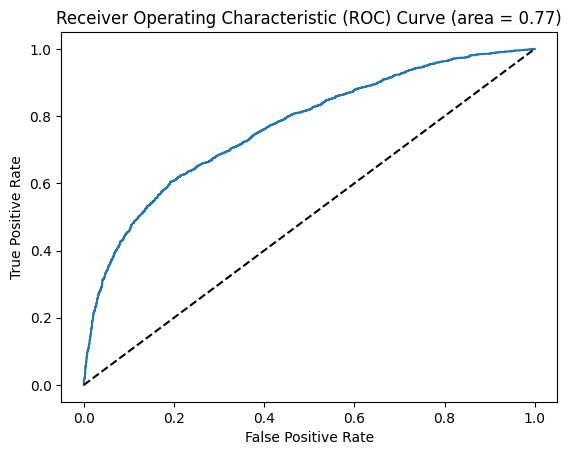

Classification Report of Test
               precision    recall  f1-score   support

           0       0.84      0.95      0.89      7009
           1       0.65      0.35      0.46      1991

    accuracy                           0.81      9000
   macro avg       0.74      0.65      0.67      9000
weighted avg       0.79      0.81      0.79      9000



In [14]:
print_stats(test_Y,test_predict_Y,test_predict_proba_Y)